In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using TensorFlow backend.


In [2]:
os.listdir("./csv")

['test.csv', 'train.csv', 'sample_submission.csv']

In [3]:
df_train = pd.read_csv('./csv/train.csv')
df_test = pd.read_csv('./csv/test.csv')
df_submit = pd.read_csv('./csv/sample_submission.csv')


In [4]:
df_train.shape, df_test.shape, df_submit.shape

((891, 12), (418, 11), (418, 2))

In [5]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
df_submit.columns

Index(['PassengerId', 'Survived'], dtype='object')

In [7]:
df_test.columns # Survived가 없음.

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
df_train.head()
#Pclass : 티켓 클래스
#sibsp : 함께 탑승한 형제자매, 배우자 수 총합
#parch : 함께 탑승한 부모, 자녀 수 총합
#cabin : 객실 넘버
#bembarked : 탑승 항구

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [9]:
df_submit.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [10]:
df_train.describe() # Age가 다른 지표와 달리 count가 다름

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [11]:
df_train.isnull().sum() / df_train.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [12]:
df_test.isnull().sum() / df_test.shape[0] # train, test 셋 모두 Age 지표에 약 20% null 값이 존재

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

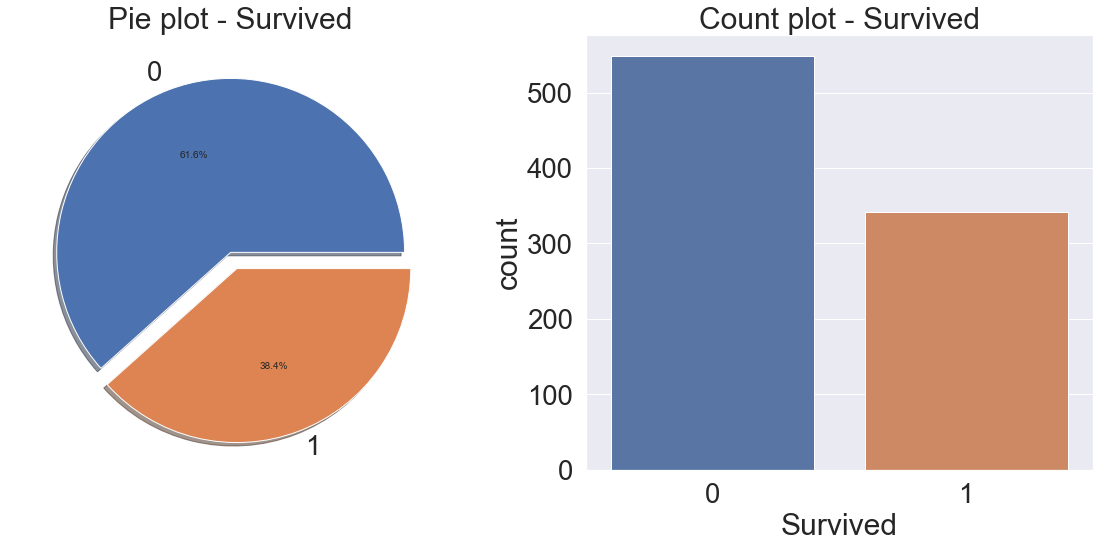

In [13]:
f, ax = plt.subplots(1, 2, figsize=(20, 8))

# 'Survived'를 원형그래프로 표현
df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

In [14]:
# pclass 그룹 별 데이터 카운트
# Plcass와 survived의 관계를 알기 위한 작업
# Plcass값을 가진 데이터 중 Survived의 값을 가진 갯수
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()


Survived
Pclass          
1            216
2            184
3            491

In [15]:
# pclass 그룹 별 생존자 수 합
# 총 합을 나타내므로 생존자 수를 알 수 있다.
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()

Survived
Pclass          
1            136
2             87
3            119

In [16]:
# 위와 같은 작업을 crosstab으로 편하게 할 수 있습니다.
# SQL에서 join과 비슷한 역할
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True)

Survived    0    1  All
Pclass                 
1          80  136  216
2          97   87  184
3         372  119  491
All       549  342  891

In [17]:
# pclass 그룹 별 생존률
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean()

Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

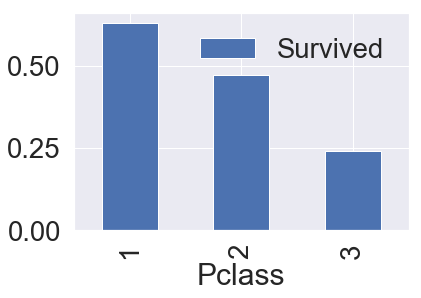

In [18]:
# 생존률을 시각화.
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().plot.bar()

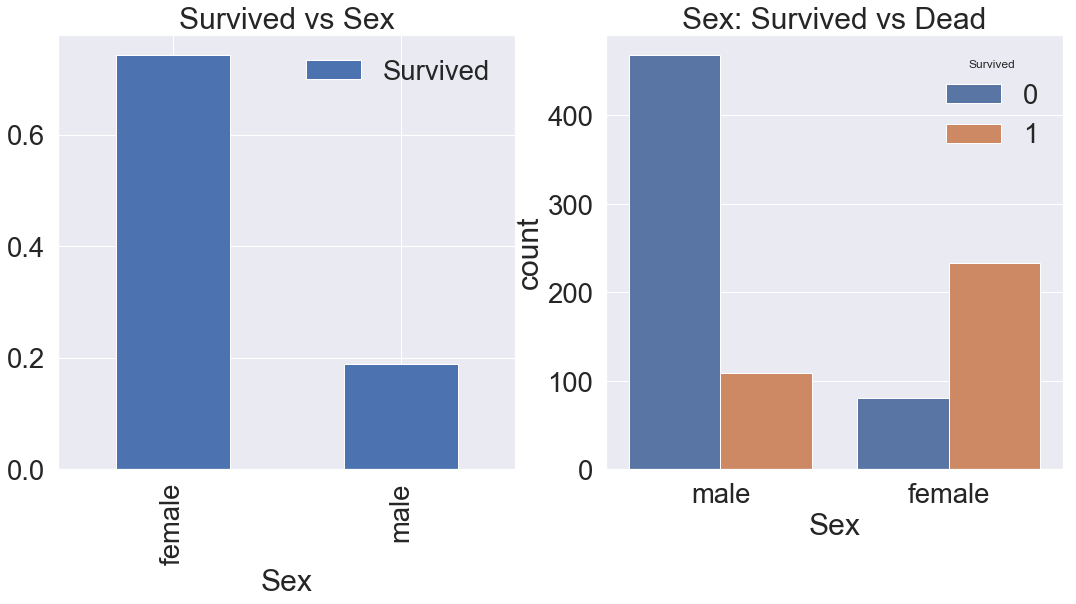

In [19]:
# 성별도 마찬가지로 시각화 했을 때 생존에 영향을 미치는 것으로 판단할 수 있다.

f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

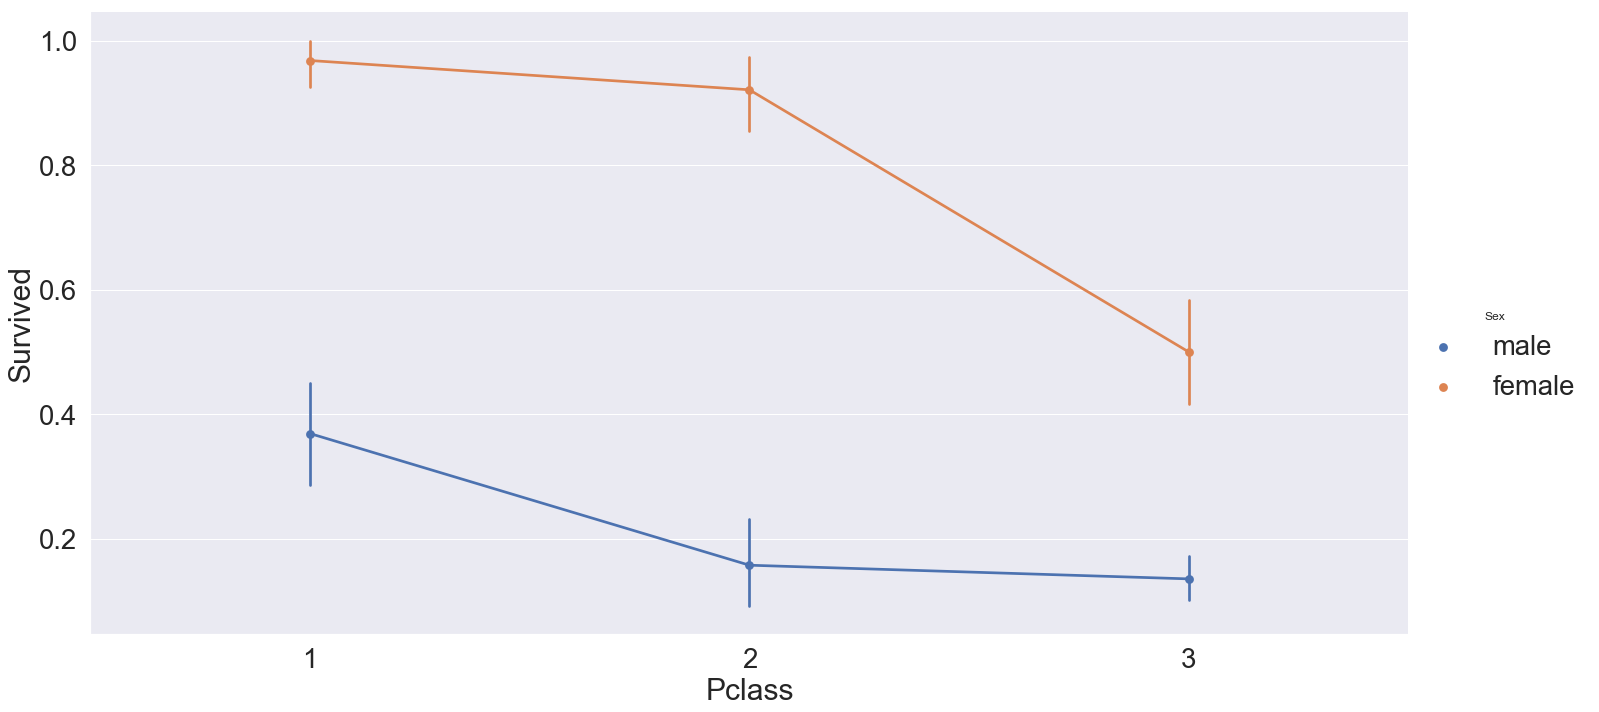

In [20]:
# Pclass, sex 두가지에 대해서 생존을 나타낸 그래프
sns.factorplot('Pclass', 'Survived', hue='Sex', data=df_train, size=10, aspect=2)

In [21]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


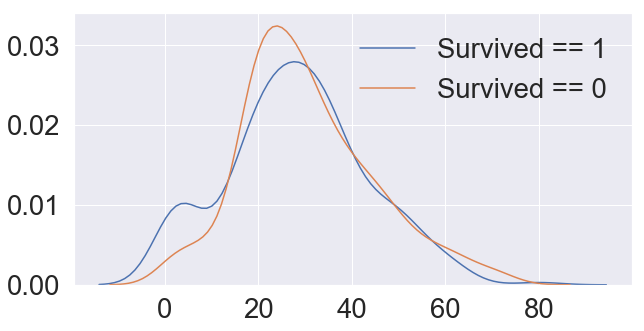

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

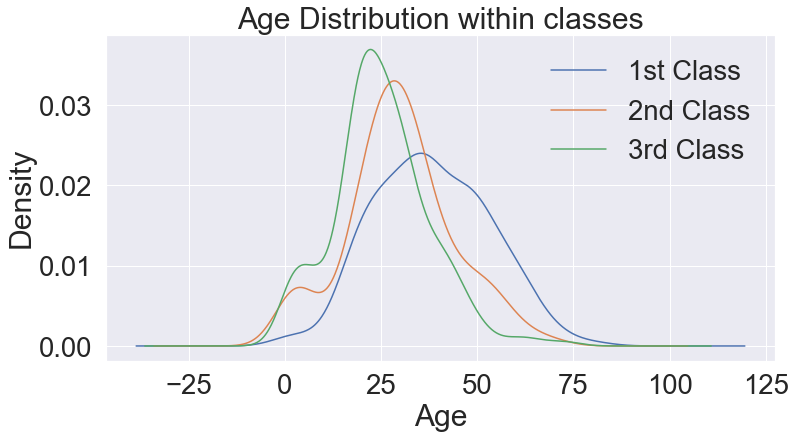

In [23]:
# 나이에 따른 등급 비율

plt.figure(figsize=(12, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.ylabel('Density')
plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

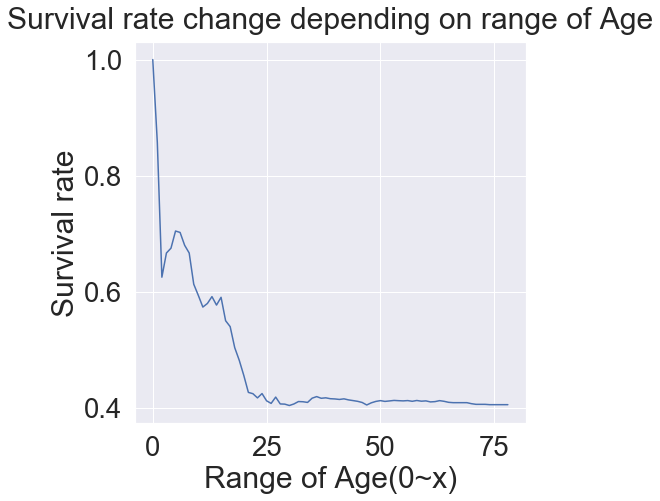

In [24]:
# 나이 별로 누적된 값을 저장할 리스트
cummulate_survival_ratio = []

# 나이 별 생존률 저장 
for i in range(1, 80):
    cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum() / len(df_train[df_train['Age'] < i]['Survived']))

# list의 index 갯수가 80이므로 가로축이 80까지 나타나는 것임.
plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()


In [25]:
# 값들의 종류를 나타냄
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

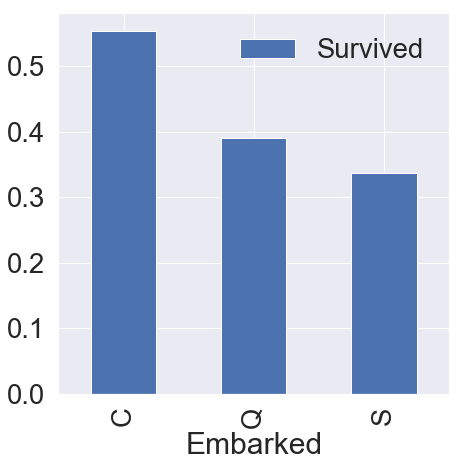

In [26]:
# 그래프로 나타내고 싶은 값을 .plot.bar 처럼 그래프 모양을 지정해준다.
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

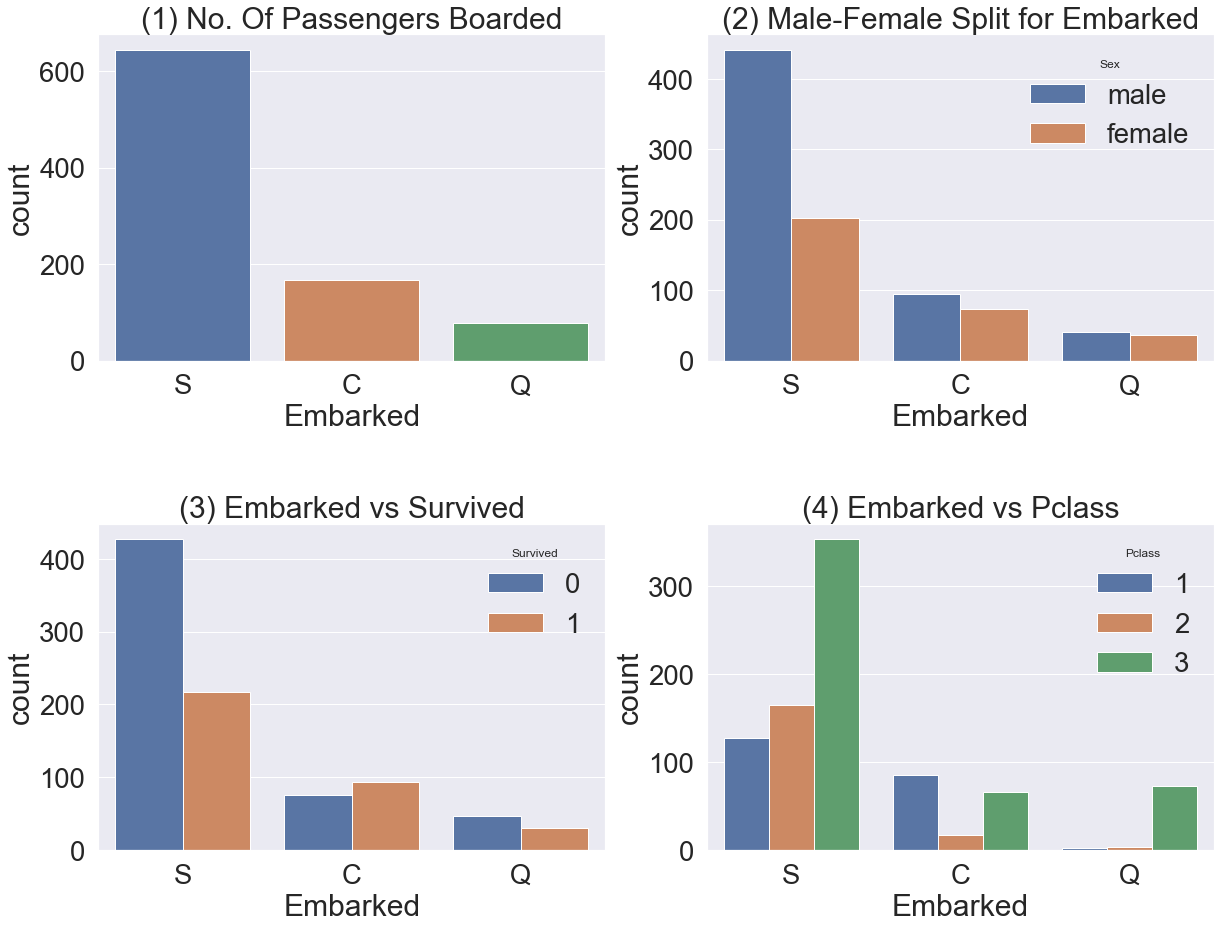

In [27]:
f,ax=plt.subplots(2, 2, figsize=(20,15))
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [28]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

In [29]:
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


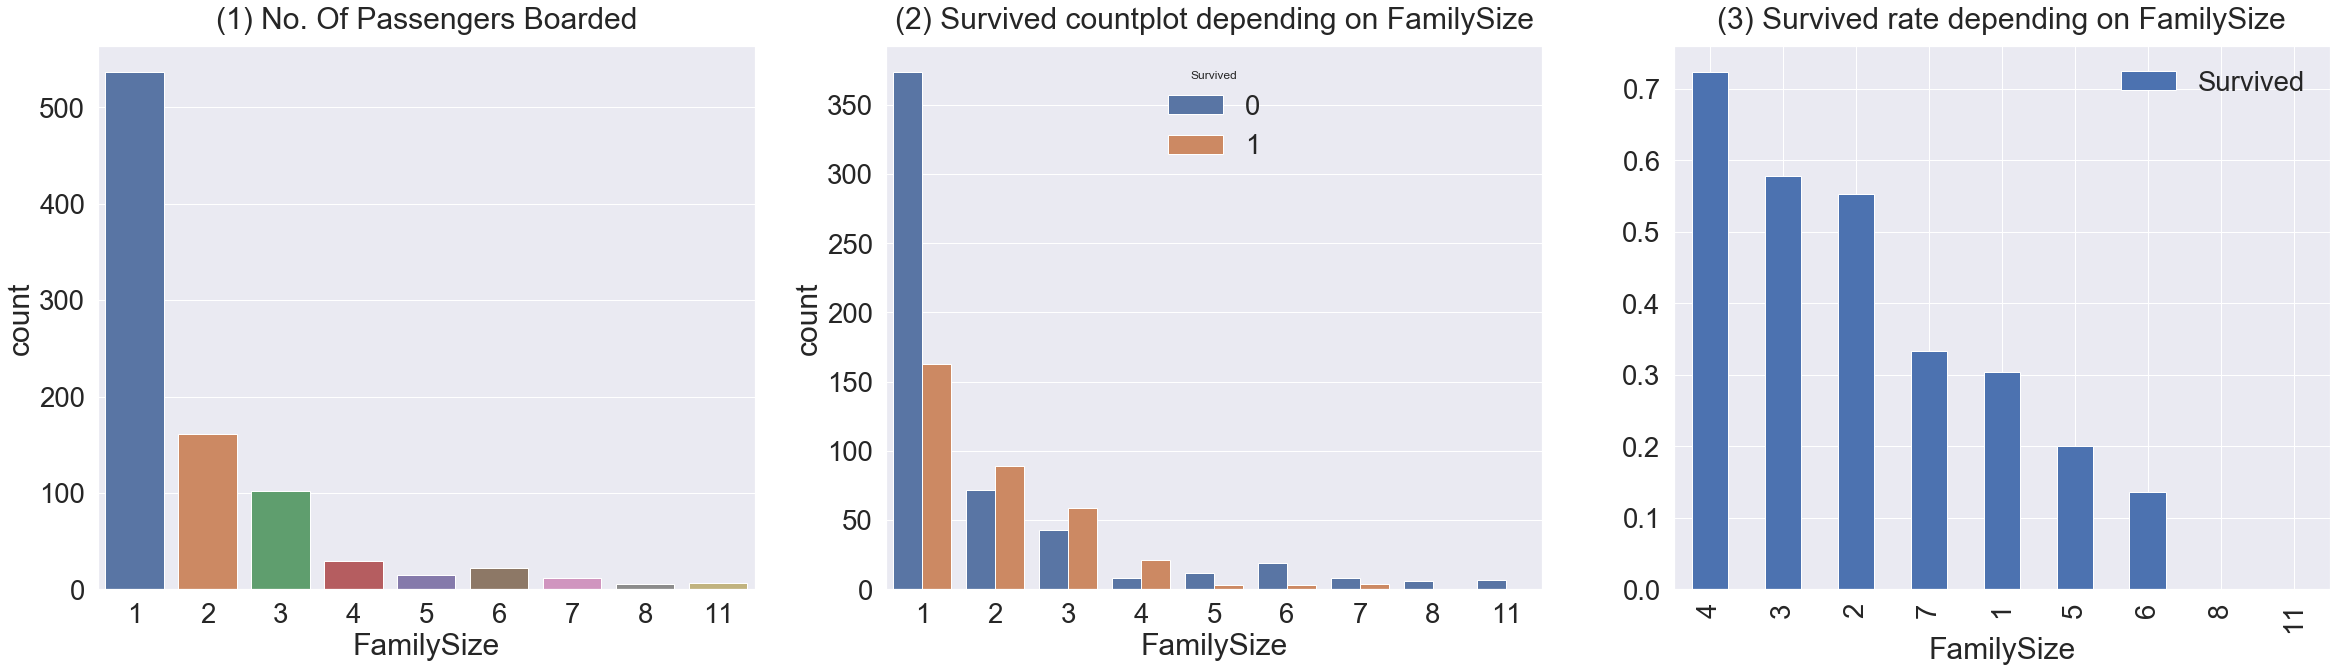

In [30]:
f,ax=plt.subplots(1, 3, figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',  y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize',  y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

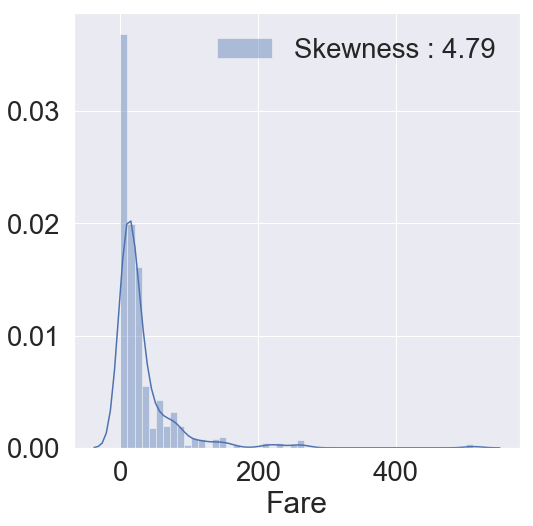

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

In [32]:
# 특이하기도 train set 말고 test set에 Fare 피쳐에 널 값이 하나 존재하는 것을 확인할 수 있었습니다.
# 그래서 평균 값으로 해당 널값을 넣어줍니다.
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset 에 있는 nan value 를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

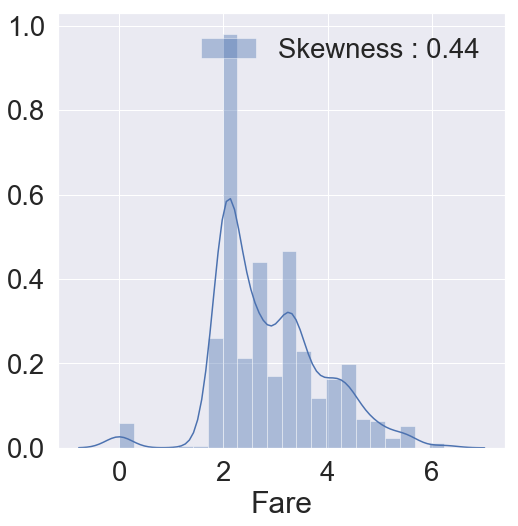

In [33]:
# log를 취해줌으로써 위에 그래프처럼 비대칭적으로 분포하던 그래프를 어느정도 맞춰줌.
# 이렇게 보다 더 좋은 성능을 내기 위해서 feature들에 여러 조작을 하거나 새로운 feature를 추가하는 것을
# feature engineering이라 한다.

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')


In [34]:
# Ticket은 다양한 string 값을 가지기 때문에 이를 위한 방법이 필요함.

df_train['Ticket'].value_counts()

CA. 2343              7
347082                7
1601                  7
CA 2144               6
3101295               6
347088                6
S.O.C. 14879          5
382652                5
W./C. 6608            4
LINE                  4
4133                  4
19950                 4
347077                4
113760                4
113781                4
PC 17757              4
17421                 4
349909                4
2666                  4
345773                3
29106                 3
C.A. 34651            3
PC 17572              3
363291                3
SC/Paris 2123         3
239853                3
248727                3
110152                3
PC 17582              3
347742                3
                     ..
345767                1
28228                 1
365226                1
3101265               1
230434                1
C.A. 18723            1
SOTON/OQ 392076       1
SC/PARIS 2133         1
9234                  1
29104                 1
330932          

In [35]:
# feature engineering은 실제 모델에 사용하는 것이기 때문에 꼭 test 데이터에도 적용시켜야한다.
# Age feature가 null 값을 가지고 있는 데아터가 존재
# null 값을 채워주기 위해 이름을 기준으로 null 값을 채워준다.

df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [69]:
# 이름별 정렬을 해보니 Mr, Miss, Mrs, Master가 가장 많다.
# 그러므로 2개 이상 집계된 이름을 성별 지표를 보고 Mr, Mrs, Miss로 나눠준다. 그 이외에는 Other
pd.crosstab(df_train['Initial'], df_train['Sex']).sum(axis=1).sort_values(ascending=False)

Initial
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Countess      1
Don           1
Sir           1
Jonkheer      1
Lady          1
Mme           1
Ms            1
Capt          1
dtype: int64

In [70]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [71]:
df_train.groupby('Initial').mean()

PassengerId  Survived    Pclass        Age     SibSp     Parch  \
Initial                                                                   
Master    414.975000  0.575000  2.625000   4.574167  2.300000  1.375000   
Miss      411.741935  0.704301  2.284946  21.860000  0.698925  0.537634   
Mr        455.880907  0.162571  2.381853  32.739609  0.293006  0.151229   
Mrs       456.393701  0.795276  1.984252  35.981818  0.692913  0.818898   
Other     564.444444  0.111111  1.666667  45.888889  0.111111  0.111111   

             Fare  FamilySize  
Initial                        
Master   3.340710    4.675000  
Miss     3.123713    2.236559  
Mr       2.651507    1.444234  
Mrs      3.443751    2.511811  
Other    2.641605    1.222222

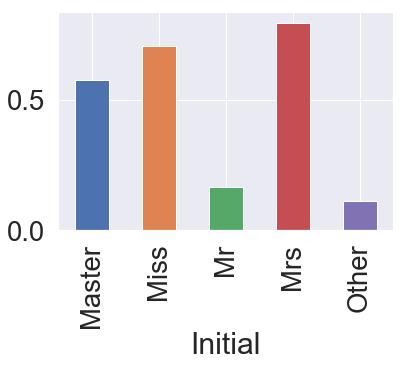

In [72]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [75]:
# 각 지표의 평균치를 보고 그에 맞도록 null 값에 입력
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

In [76]:
# Age feature에서 null 값이 없어진 것을 확인할 수 있음.

df_train.isnull().sum()[df_train.isnull().sum() > 0]

Cabin       687
Embarked      2
dtype: int64

In [77]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


In [80]:
# null 값이 2개밖에 없고 S가 가장 많으므로 S로 채움
df_train['Embarked'].fillna('S', inplace=True)

In [81]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]

Cabin    687
dtype: int64

In [82]:
# Age는 continuous feature이므로 category화 시켜준다.
# 하지만 continuous를 categorical로 바꾸면 information loss가 발생할수도 있다는 점 주의할 것.

def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

In [83]:
df_train.groupby(['Age_cat'])['PassengerId'].count()

Age_cat
0     66
1    102
2    256
3    304
4     89
5     48
6     19
7      7
Name: PassengerId, dtype: int64

In [84]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [85]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [86]:
df_train['Embarked'].isnull().any() , df_train['Embarked'].dtypes

(False, dtype('int64'))

In [87]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

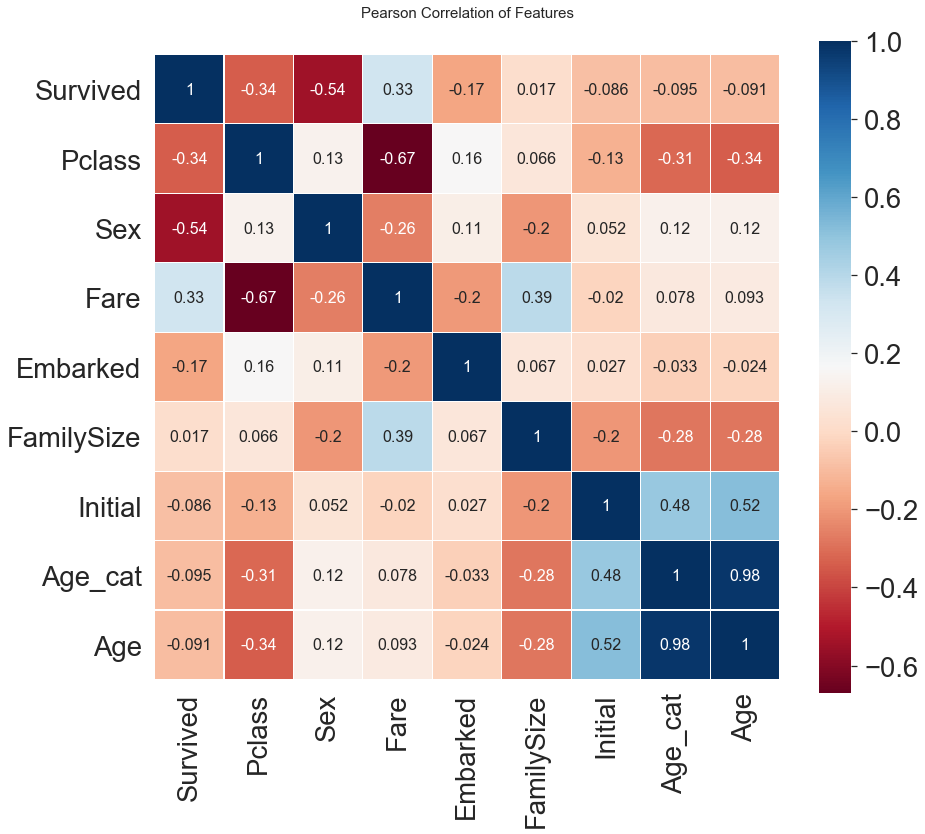

In [88]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat', 'Age']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

In [89]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [90]:
# Initial feature가 벡터 형태로 변환된 것을 확인할 수 있음.
df_train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket      Fare Cabin  Embarked  FamilySize  Age_cat  Initial_0  \
0         A/5 21171  1.981001   NaN         2           2        2          0   
1          PC 17599  4.266662   C85         0           2        3          0   
2  STON/O2. 3101282  2.070022   NaN         2           1        2          0   
3            113803  3.972177  C123         2           2        3          0   
4            373450  2.085672   NaN         2           1        3          0   

   Initial_1  Initial_2  Initial_3  Initial_4  
0          0          1          0          0  
1          0          0          1          0  
2          1          0          0          0  
3          0          0          1          0  
4          0          1          0          0

In [91]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [92]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [93]:
df_train.head()

Survived  Pclass  Sex   Age      Fare  FamilySize  Age_cat  Initial_0  \
0         0       3    1  22.0  1.981001           2        2          0   
1         1       1    0  38.0  4.266662           2        3          0   
2         1       3    0  26.0  2.070022           1        2          0   
3         1       1    0  35.0  3.972177           2        3          0   
4         0       3    1  35.0  2.085672           1        3          0   

   Initial_1  Initial_2  Initial_3  Initial_4  Embarked_0  Embarked_1  \
0          0          1          0          0           0           0   
1          0          0          1          0           1           0   
2          1          0          0          0           0           0   
3          0          0          1          0           0           0   
4          0          1          0          0           0           0   

   Embarked_2  
0           1  
1           0  
2           1  
3           1  
4           1

In [94]:
df_train.dtypes

Survived        int64
Pclass          int64
Sex             int64
Age           float64
Fare          float64
FamilySize      int64
Age_cat         int64
Initial_0       uint8
Initial_1       uint8
Initial_2       uint8
Initial_3       uint8
Initial_4       uint8
Embarked_0      uint8
Embarked_1      uint8
Embarked_2      uint8
dtype: object

In [95]:
df_test.head()

Pclass  Sex   Age      Fare  FamilySize  Age_cat  Initial_0  Initial_1  \
0       3    1  34.5  2.057860           1        3          0          0   
1       3    0  47.0  1.945910           2        4          0          0   
2       2    1  62.0  2.270836           1        6          0          0   
3       3    1  27.0  2.159003           1        2          0          0   
4       3    0  22.0  2.508582           3        2          0          0   

   Initial_2  Initial_3  Initial_4  Embarked_0  Embarked_1  Embarked_2  
0          1          0          0           0           1           0  
1          0          1          0           0           0           1  
2          1          0          0           0           1           0  
3          1          0          0           0           0           1  
4          0          1          0           0           0           1

In [96]:
df_test.dtypes

Pclass          int64
Sex             int64
Age           float64
Fare          float64
FamilySize      int64
Age_cat         int64
Initial_0       uint8
Initial_1       uint8
Initial_2       uint8
Initial_3       uint8
Initial_4       uint8
Embarked_0      uint8
Embarked_1      uint8
Embarked_2      uint8
dtype: object

In [97]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다
from sklearn.model_selection import train_test_split # traning set을 쉽게 나눠주는 함수입니다.

In [98]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [99]:
X_train.shape, X_test.shape

((891, 14), (418, 14))

In [100]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.2, random_state=2018)

In [101]:
y_tr.shape, y_vld.shape

((712,), (179,))

In [114]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [115]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 179명 중 83.24% 정확도로 생존을 맞춤


In [117]:
# pandas를 이용해 feature importance를 알 수 있음.


from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

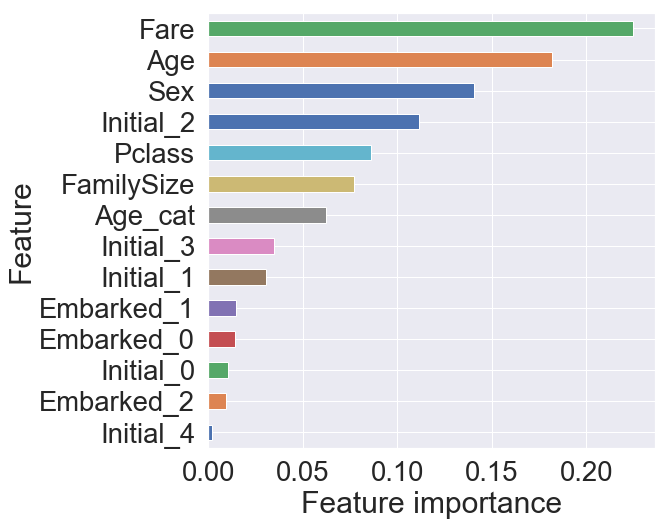

In [118]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [119]:
# keras를 사용한 NN 모델 기반 

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam, SGD


In [135]:
nn_model = Sequential()
# input 14, output 32, relu 사용
nn_model.add(Dense(32,activation='relu', input_shape=(14,)))
nn_model.add(Dropout(0,4))
nn_model.add(Dense(64,activation='relu'))
nn_model.add(Dropout(0,4))
nn_model.add(Dense(32,activation='relu'))
nn_model.add(Dropout(0,4))
# binary classification이기 때문에 마지막은 output 1, sigmoid 함수 사용
nn_model.add(Dense(1,activation='sigmoid'))

Loss = 'binary_crossentropy'
nn_model.compile(loss=Loss,optimizer=Adam(),metrics=['accuracy'])
nn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                480       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                

In [136]:
history = nn_model.fit(X_tr,y_tr,
                    batch_size=64,
                    epochs=500,
                    validation_data=(X_vld, y_vld),
                    verbose=1)

Train on 712 samples, validate on 179 samples
Epoch 1/500
712/712 [==============================] - 0s 458us/step - loss: 0.7332 - accuracy: 0.5365 - val_loss: 0.6736 - val_accuracy: 0.6425
Epoch 2/500
712/712 [==============================] - 0s 49us/step - loss: 0.6661 - accuracy: 0.6601 - val_loss: 0.6192 - val_accuracy: 0.6536
Epoch 3/500
712/712 [==============================] - 0s 66us/step - loss: 0.6326 - accuracy: 0.6348 - val_loss: 0.6275 - val_accuracy: 0.8268
Epoch 4/500
712/712 [==============================] - 0s 95us/step - loss: 0.6290 - accuracy: 0.6756 - val_loss: 0.5868 - val_accuracy: 0.7039
Epoch 5/500
712/712 [==============================] - 0s 49us/step - loss: 0.5954 - accuracy: 0.6910 - val_loss: 0.5652 - val_accuracy: 0.6927
Epoch 6/500
712/712 [==============================] - 0s 47us/step - loss: 0.5822 - accuracy: 0.7416 - val_loss: 0.5514 - val_accuracy: 0.6927
Epoch 7/500
712/712 [==============================] - 0s 54us/step - loss: 0.5561 - accu

712/712 [==============================] - 0s 47us/step - loss: 0.3883 - accuracy: 0.8301 - val_loss: 0.3922 - val_accuracy: 0.8492
Epoch 58/500
712/712 [==============================] - 0s 48us/step - loss: 0.3882 - accuracy: 0.8272 - val_loss: 0.3897 - val_accuracy: 0.8380
Epoch 59/500
712/712 [==============================] - 0s 51us/step - loss: 0.3875 - accuracy: 0.8272 - val_loss: 0.3876 - val_accuracy: 0.8492
Epoch 60/500
712/712 [==============================] - 0s 46us/step - loss: 0.3855 - accuracy: 0.8329 - val_loss: 0.4280 - val_accuracy: 0.8045
Epoch 61/500
712/712 [==============================] - 0s 49us/step - loss: 0.4021 - accuracy: 0.8090 - val_loss: 0.3896 - val_accuracy: 0.8324
Epoch 62/500
712/712 [==============================] - 0s 42us/step - loss: 0.3856 - accuracy: 0.8343 - val_loss: 0.3873 - val_accuracy: 0.8380
Epoch 63/500
712/712 [==============================] - 0s 47us/step - loss: 0.3901 - accuracy: 0.8301 - val_loss: 0.3872 - val_accuracy: 0.838

712/712 [==============================] - 0s 45us/step - loss: 0.3754 - accuracy: 0.8343 - val_loss: 0.3997 - val_accuracy: 0.8324
Epoch 114/500
712/712 [==============================] - 0s 272us/step - loss: 0.3846 - accuracy: 0.8244 - val_loss: 0.4079 - val_accuracy: 0.8156
Epoch 115/500
712/712 [==============================] - 0s 50us/step - loss: 0.3786 - accuracy: 0.8216 - val_loss: 0.3966 - val_accuracy: 0.8436
Epoch 116/500
712/712 [==============================] - 0s 45us/step - loss: 0.3725 - accuracy: 0.8371 - val_loss: 0.3966 - val_accuracy: 0.8380
Epoch 117/500
712/712 [==============================] - 0s 42us/step - loss: 0.3807 - accuracy: 0.8357 - val_loss: 0.4008 - val_accuracy: 0.8380
Epoch 118/500
712/712 [==============================] - 0s 47us/step - loss: 0.3716 - accuracy: 0.8413 - val_loss: 0.3908 - val_accuracy: 0.8324
Epoch 119/500
712/712 [==============================] - 0s 33us/step - loss: 0.3762 - accuracy: 0.8385 - val_loss: 0.3994 - val_accuracy

712/712 [==============================] - 0s 43us/step - loss: 0.3654 - accuracy: 0.8329 - val_loss: 0.3972 - val_accuracy: 0.8380
Epoch 170/500
712/712 [==============================] - 0s 46us/step - loss: 0.3617 - accuracy: 0.8455 - val_loss: 0.3993 - val_accuracy: 0.8324
Epoch 171/500
712/712 [==============================] - 0s 60us/step - loss: 0.3636 - accuracy: 0.8455 - val_loss: 0.3992 - val_accuracy: 0.8380
Epoch 172/500
712/712 [==============================] - 0s 46us/step - loss: 0.3623 - accuracy: 0.8385 - val_loss: 0.4008 - val_accuracy: 0.8268
Epoch 173/500
712/712 [==============================] - 0s 54us/step - loss: 0.3662 - accuracy: 0.8385 - val_loss: 0.4035 - val_accuracy: 0.8324
Epoch 174/500
712/712 [==============================] - 0s 44us/step - loss: 0.3669 - accuracy: 0.8385 - val_loss: 0.4076 - val_accuracy: 0.8268
Epoch 175/500
712/712 [==============================] - 0s 47us/step - loss: 0.3611 - accuracy: 0.8469 - val_loss: 0.4054 - val_accuracy:

712/712 [==============================] - 0s 59us/step - loss: 0.3552 - accuracy: 0.8427 - val_loss: 0.4016 - val_accuracy: 0.8380
Epoch 226/500
712/712 [==============================] - 0s 45us/step - loss: 0.3553 - accuracy: 0.8427 - val_loss: 0.4000 - val_accuracy: 0.8324
Epoch 227/500
712/712 [==============================] - ETA: 0s - loss: 0.3047 - accuracy: 0.87 - 0s 58us/step - loss: 0.3574 - accuracy: 0.8469 - val_loss: 0.4001 - val_accuracy: 0.8268
Epoch 228/500
712/712 [==============================] - 0s 60us/step - loss: 0.3607 - accuracy: 0.8287 - val_loss: 0.4007 - val_accuracy: 0.8380
Epoch 229/500
712/712 [==============================] - 0s 98us/step - loss: 0.3689 - accuracy: 0.8399 - val_loss: 0.4190 - val_accuracy: 0.8156
Epoch 230/500
712/712 [==============================] - 0s 62us/step - loss: 0.3607 - accuracy: 0.8483 - val_loss: 0.4044 - val_accuracy: 0.8324
Epoch 231/500
712/712 [==============================] - 0s 51us/step - loss: 0.3534 - accuracy:

Epoch 281/500
712/712 [==============================] - 0s 46us/step - loss: 0.3491 - accuracy: 0.8497 - val_loss: 0.4109 - val_accuracy: 0.8212
Epoch 282/500
712/712 [==============================] - 0s 38us/step - loss: 0.3435 - accuracy: 0.8525 - val_loss: 0.4119 - val_accuracy: 0.8324
Epoch 283/500
712/712 [==============================] - 0s 36us/step - loss: 0.3440 - accuracy: 0.8525 - val_loss: 0.4158 - val_accuracy: 0.8212
Epoch 284/500
712/712 [==============================] - 0s 34us/step - loss: 0.3463 - accuracy: 0.8483 - val_loss: 0.4152 - val_accuracy: 0.8436
Epoch 285/500
712/712 [==============================] - 0s 38us/step - loss: 0.3534 - accuracy: 0.8525 - val_loss: 0.4235 - val_accuracy: 0.8268
Epoch 286/500
712/712 [==============================] - 0s 33us/step - loss: 0.3578 - accuracy: 0.8497 - val_loss: 0.4181 - val_accuracy: 0.8380
Epoch 287/500
712/712 [==============================] - 0s 38us/step - loss: 0.3468 - accuracy: 0.8483 - val_loss: 0.4121 -

Epoch 337/500
712/712 [==============================] - 0s 38us/step - loss: 0.3568 - accuracy: 0.8315 - val_loss: 0.4392 - val_accuracy: 0.8380
Epoch 338/500
712/712 [==============================] - 0s 43us/step - loss: 0.3553 - accuracy: 0.8441 - val_loss: 0.4532 - val_accuracy: 0.8268
Epoch 339/500
712/712 [==============================] - 0s 55us/step - loss: 0.3469 - accuracy: 0.8497 - val_loss: 0.4083 - val_accuracy: 0.8492
Epoch 340/500
712/712 [==============================] - 0s 45us/step - loss: 0.3429 - accuracy: 0.8539 - val_loss: 0.4162 - val_accuracy: 0.8324
Epoch 341/500
712/712 [==============================] - 0s 39us/step - loss: 0.3370 - accuracy: 0.8596 - val_loss: 0.4086 - val_accuracy: 0.8380
Epoch 342/500
712/712 [==============================] - 0s 34us/step - loss: 0.3492 - accuracy: 0.8539 - val_loss: 0.4191 - val_accuracy: 0.8324
Epoch 343/500
712/712 [==============================] - 0s 43us/step - loss: 0.3539 - accuracy: 0.8511 - val_loss: 0.4310 -

712/712 [==============================] - 0s 42us/step - loss: 0.3376 - accuracy: 0.8581 - val_loss: 0.4360 - val_accuracy: 0.8324
Epoch 394/500
712/712 [==============================] - 0s 42us/step - loss: 0.3325 - accuracy: 0.8553 - val_loss: 0.4250 - val_accuracy: 0.8380
Epoch 395/500
712/712 [==============================] - 0s 40us/step - loss: 0.3335 - accuracy: 0.8596 - val_loss: 0.4337 - val_accuracy: 0.8268
Epoch 396/500
712/712 [==============================] - 0s 44us/step - loss: 0.3311 - accuracy: 0.8567 - val_loss: 0.4266 - val_accuracy: 0.8436
Epoch 397/500
712/712 [==============================] - 0s 39us/step - loss: 0.3501 - accuracy: 0.8469 - val_loss: 0.4379 - val_accuracy: 0.8380
Epoch 398/500
712/712 [==============================] - 0s 35us/step - loss: 0.3484 - accuracy: 0.8610 - val_loss: 0.4234 - val_accuracy: 0.8436
Epoch 399/500
712/712 [==============================] - 0s 35us/step - loss: 0.3319 - accuracy: 0.8553 - val_loss: 0.4493 - val_accuracy:

712/712 [==============================] - 0s 37us/step - loss: 0.3269 - accuracy: 0.8624 - val_loss: 0.4463 - val_accuracy: 0.8380
Epoch 450/500
712/712 [==============================] - 0s 60us/step - loss: 0.3276 - accuracy: 0.8652 - val_loss: 0.4390 - val_accuracy: 0.8380
Epoch 451/500
712/712 [==============================] - 0s 40us/step - loss: 0.3334 - accuracy: 0.8652 - val_loss: 0.4338 - val_accuracy: 0.8380
Epoch 452/500
712/712 [==============================] - 0s 74us/step - loss: 0.3336 - accuracy: 0.8596 - val_loss: 0.4612 - val_accuracy: 0.8324
Epoch 453/500
712/712 [==============================] - 0s 35us/step - loss: 0.3393 - accuracy: 0.8553 - val_loss: 0.4477 - val_accuracy: 0.8268
Epoch 454/500
712/712 [==============================] - 0s 42us/step - loss: 0.3289 - accuracy: 0.8652 - val_loss: 0.4592 - val_accuracy: 0.8212
Epoch 455/500
712/712 [==============================] - 0s 71us/step - loss: 0.3257 - accuracy: 0.8596 - val_loss: 0.4331 - val_accuracy:

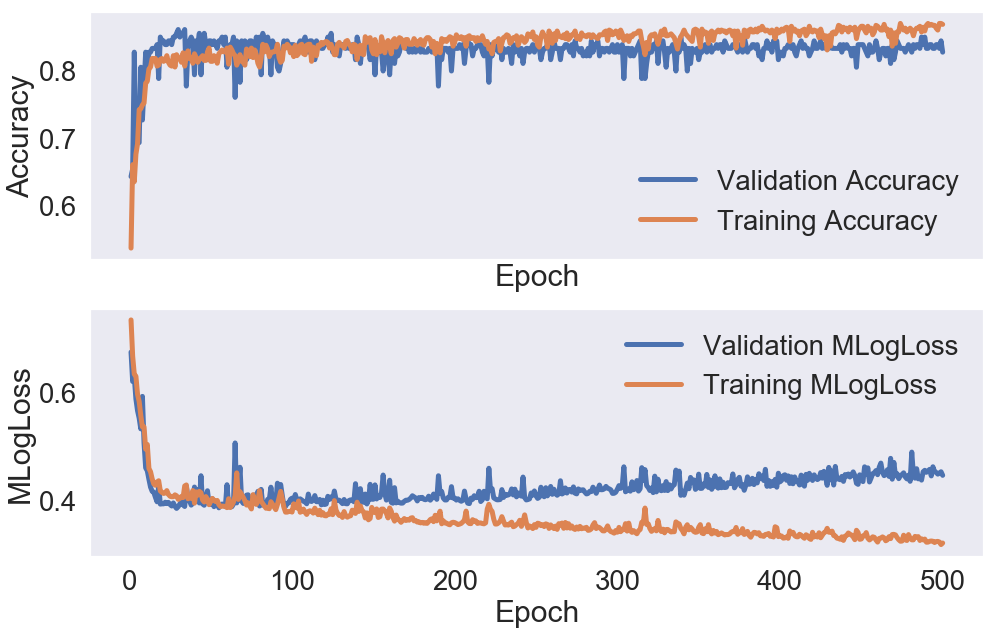

In [137]:
hists = [history]
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_loss, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.loss, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [139]:
submission = pd.read_csv('./csv/sample_submission.csv')
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [140]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [141]:
submission.to_csv('my_first_submission.csv', index=False)

In [142]:
submission = pd.read_csv('./csv/sample_submission.csv')
prediction = nn_model.predict(X_test)
prediction = prediction > 0.5
prediction = prediction.astype(np.int)
prediction = prediction.T[0]
prediction.shape

(418,)

In [143]:
submission['Survived'] = prediction
submission.to_csv('my_nn_submission.csv', index=False)